FASTA format function from problem description:

In [1]:
def read_fasta_file(filename):
    """
    Reads the given FASTA file f and returns a dictionary of sequences.

    Lines starting with ';' in the FASTA file are ignored.
    """
    sequences_lines = {}
    current_sequence_lines = None
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            if line.startswith(';') or not line:
                continue
            if line.startswith('>'):
                sequence_name = line.lstrip('>')
                current_sequence_lines = []
                sequences_lines[sequence_name] = current_sequence_lines
            else:
                if current_sequence_lines is not None:
                    current_sequence_lines.append(line)
    sequences = {}
    for name, lines in sequences_lines.items():
        sequences[name] = ''.join(lines)
    return sequences

In [2]:
def write_fasta_file(annotation_file_to_save, annotation_string, genome_file=None):
    if (genome_file!=None):
        with open(genome_file) as gf:
            first_line = gf.readline()
            s = " "
            words = first_line.split(s)
            words[0] = words[0] + " gene annotation"
            first_line = s.join(words[:-1])
    else:
        first_line = "; gene annotation"
    with open(annotation_file_to_save, 'w+') as af:
        af.write(first_line + '\n')
        name = annotation_file_to_save.replace('/', '\\').split('\\')[-1].split('.fa')[0]
        af.write('>' + name + '\n')
        line_length = 60
        full_lines = len(annotation_string)//line_length
        for anot_line in range(full_lines):
            af.write(annotation_string[anot_line*line_length:(anot_line+1)*line_length] + '\n')
        af.write(annotation_string[(full_lines)*line_length:])
       
    
# eg
write_fasta_file("data/annotation13.fa", "ABABABABABABABABABAAAAJHASJHASJJSdskfjklsfkjklj sdhjkøfhjkø ksdhjf jkjkhsdfjk hjksdf hjksdfjk jhksd fhjkdsfhjk AJJSJHASHJASJJHASJHASJHASJHSAJJHASJHASHJASJJHASJHASJJHASJH")

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

genome = ''
annotation = ''
origin_genomes = [1, 2, 3, 5]
for i in origin_genomes:
    genome += read_fasta_file('data/genome%d.fa' % i)['genome%d' % i]
    annotation += read_fasta_file('data/annotation%d.fa' % i)['annotation%d' % i]

print(len(genome), len(annotation))

filename = 'codon_hmm_excl4.npz'

9248220 9248220


R_to_C: 3
C_to_R: 1


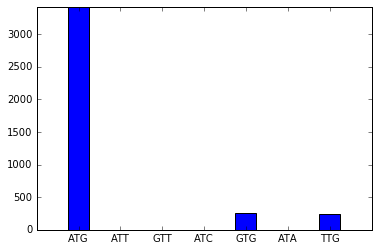

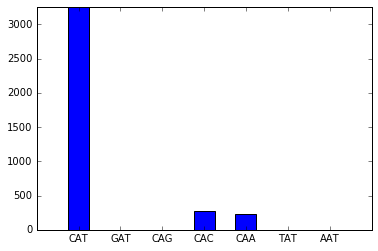

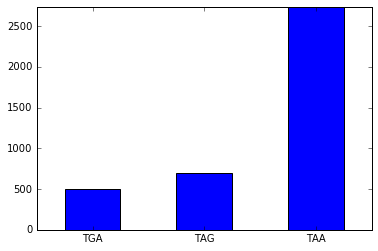

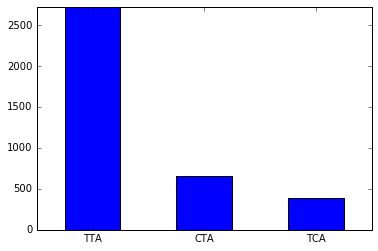

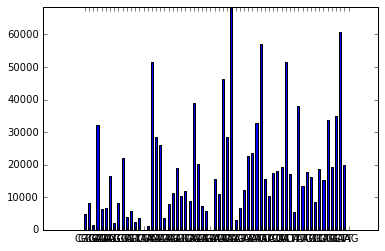

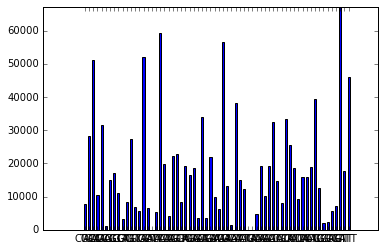

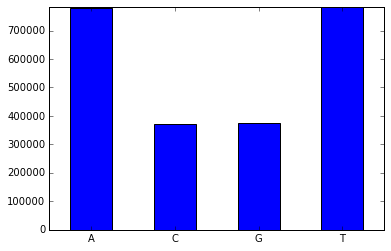

In [4]:
def addCodon(codon, start, stop, content):
    if len(codon) >= 1:
        start[codon[0]] += 1
        if len(codon[1:-1]) < 1:
            print('tis')
        for c in codon[1:-1]:
            content[c] += 1
        stop[codon[-1]] += 1


def hist_from_dict(d):
    plt.figure()
    X = np.arange(len(d))
    plt.bar(X, d.values(), align='center', width=0.5)
    plt.xticks(X, d.keys())
    ymax = max(d.values()) + 1
    plt.ylim(0, ymax)
    plt.show()

C_start = defaultdict(lambda: 0)
C_stop = defaultdict(lambda: 0)
C_content = defaultdict(lambda: 0)

R_start = defaultdict(lambda: 0)
R_stop = defaultdict(lambda: 0)
R_content = defaultdict(lambda: 0)

N_content = defaultdict(lambda: 0)

state = 'N'
i = 0


R_to_C = 0
C_to_R = 0
gene = list()
while i < len(annotation):
    if annotation[i] == 'C':
        if state == 'R':
            C_to_R += 1
            addCodon(gene, R_start, R_stop, R_content)
            gene = list()
        state = 'C'
        gene.append(genome[i:i+3])
        i += 3
    elif annotation[i] == 'R':
        if state == 'C':
            R_to_C += 1
            addCodon(gene, C_start, C_stop, C_content)
            gene = list()
        state = 'R'
        gene.append(genome[i:i+3])
        i += 3
    else:
        if state != 'N':
            if state == 'C':
                addCodon(gene, C_start, C_stop, C_content)
            elif state == 'R':
                addCodon(gene, R_start, R_stop, R_content)
            gene = list()
            state = 'N'
        N_content[genome[i]] += 1
        i = i+1

print('R_to_C:', R_to_C)
print('C_to_R:', C_to_R)
        
hist_from_dict(C_start)
hist_from_dict(R_stop)

hist_from_dict(C_stop)
hist_from_dict(R_start)

hist_from_dict(C_content)
hist_from_dict(R_content)

N_content.pop('TG', None)
N_content.pop('GC', None)
#N_content.pop('G', None)
#N_content.pop('C', None)
hist_from_dict(N_content)
        

In [5]:
## Codon model


# define states
print('\nThe seven states, and their codes:')  
state_desc = ['Noncoding', 
              'C-start',
              'C-codon',
              'C-stop',
              'R-start',
              'R-codon',
              'R-stop']
state_codes = ['N', 'C', 'C', 'C', 'R', 'R', 'R']
print(np.vstack([state_desc, state_codes]))


# define all possible outcomes of all states:
outcomes_dict = {} # ohh gawd this is akward
outcomes = np.empty([68], dtype=object) # help me, im lost
i = 0
letters = 'ACGT'
for letter1 in letters:
    outcomes[i] = letter1
    outcomes_dict[letter1] = i
    i += 1
    for letter2 in letters:
        for letter3 in letters:
            outcomes[i] = letter1 + letter2 + letter3
            outcomes_dict[letter1 + letter2 + letter3] = i
            i += 1
print('\nThe 4^3 + 4 = 68 possible emissions are:')  
print(outcomes)
print(outcomes_dict)


# oh so pretty!
def float_formatter(x):
    if x < 0.001 and x > 0:
        return "   >0" 
    elif x == 0:
        return "    0" 
    else:
        return "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})


## define the probabilities for each to state to emit any outcome:
emission_countings = np.zeros([len(state_desc), len(outcomes)])
emission = np.zeros([len(state_desc), len(outcomes)])
state_countings = [N_content, C_start, C_content, C_stop, R_stop, R_content, R_start]
for idx, state in enumerate(state_countings):
    #print()
    #print('State: ' + state_desc[idx])
    for key in state.keys():
        emission_countings[idx, outcomes_dict[key]] = state[key]
        #print(key, state[key])
#print(emission_countings)
### Pseudo counting!
#emission_countings[(emission_countings==0)] = 1
###
emission = emission_countings / np.sum(emission_countings, axis=1)[:,None]
print('\nThe emissions probabilities are:')  
print(emission)


# define state transition probabilities
starts = 5
A_countings = np.zeros([len(state_desc), len(state_desc)])
#pseudo counting!
#A_countings = np.ones([len(state_desc), len(state_desc)]) 
# N, bemærk: N efterfølges af N igen tilsvarende antal(N) - antal(N->C + N->R) - antal(startN)
A_countings[0,0] = sum(N_content.values()) - (sum(C_stop.values()) + sum(R_stop.values()) + starts) + (C_to_R + R_to_C)
A_countings[0,1] = sum(C_start.values()) - R_to_C
A_countings[0,4] = sum(R_start.values()) - C_to_R
# C_start
A_countings[1,2] = sum(C_start.values())
# C_content
A_countings[2,2] = sum(C_content.values()) - sum(C_start.values())
A_countings[2,3] = sum(C_stop.values())
# C_stop
A_countings[3,4] = C_to_R
A_countings[3,0] = sum(C_stop.values()) 
# R_start
A_countings[4,5] = sum(R_start.values())
# R_content
A_countings[5,5] = sum(R_content.values()) - sum(R_start.values())
A_countings[5,6] = sum(R_stop.values()) 
# R_stop
A_countings[6,0] = sum(R_stop.values()) 
A_countings[6,1] = R_to_C
print('\nTransition probabilities:') 
A = A_countings / np.sum(A_countings, axis=1)[:,None]
print(A)


# define start state probabilities
### Pseudo counting
#pi = np.ones([len(state_desc),1]) * 0.001
pi = np.zeros([len(state_desc),1])
pi[0] = 1 # allways start as noncoding
pi = pi / np.sum(pi, axis=0)
print('\nStarting state probabilities (pi):') 
print(pi)

# State chart text content creation:
for idx, state in enumerate(state_desc):
    print("\n" + state)
    #print('outputs %1s' %(state_codes[idx]))
    for idy, out in enumerate(outcomes):
        p = emission[idx, idy]
        if p > 0.001:
            print('%3s %.3f' % (out, round(p,3)) )
        elif p > 0:
            print('%3s    >0' % (out) )


The seven states, and their codes:
[['Noncoding' 'C-start' 'C-codon' 'C-stop' 'R-start' 'R-codon' 'R-stop']
 ['N' 'C' 'C' 'C' 'R' 'R' 'R']]

The 4^3 + 4 = 68 possible emissions are:
['A' 'AAA' 'AAC' 'AAG' 'AAT' 'ACA' 'ACC' 'ACG' 'ACT' 'AGA' 'AGC' 'AGG'
 'AGT' 'ATA' 'ATC' 'ATG' 'ATT' 'C' 'CAA' 'CAC' 'CAG' 'CAT' 'CCA' 'CCC'
 'CCG' 'CCT' 'CGA' 'CGC' 'CGG' 'CGT' 'CTA' 'CTC' 'CTG' 'CTT' 'G' 'GAA'
 'GAC' 'GAG' 'GAT' 'GCA' 'GCC' 'GCG' 'GCT' 'GGA' 'GGC' 'GGG' 'GGT' 'GTA'
 'GTC' 'GTG' 'GTT' 'T' 'TAA' 'TAC' 'TAG' 'TAT' 'TCA' 'TCC' 'TCG' 'TCT'
 'TGA' 'TGC' 'TGG' 'TGT' 'TTA' 'TTC' 'TTG' 'TTT']
{'CGC': 27, 'TGC': 61, 'CGG': 28, 'TTG': 66, 'CAC': 19, 'CCG': 24, 'AGG': 11, 'ACG': 7, 'GTA': 47, 'TTT': 67, 'CTG': 32, 'GTT': 50, 'CCC': 23, 'TCG': 58, 'TAA': 52, 'GCT': 42, 'TTA': 64, 'ACA': 5, 'ATG': 15, 'TCC': 57, 'CAG': 20, 'T': 51, 'AGT': 12, 'ATC': 14, 'TAT': 55, 'TGG': 62, 'AGA': 9, 'GGA': 43, 'ACC': 6, 'CGA': 26, 'TGA': 60, 'GAC': 36, 'GTG': 49, 'AAT': 4, 'GCA': 39, 'AAA': 1, 'GGG': 45, 'C': 17, '

In [6]:
np.savez(filename, 
         A=A, 
         E=emission,
         pi=pi,
         outcomes=outcomes,
         outcomes_dict=outcomes_dict,
         state_codes=state_codes,
         state_desc=state_desc,
         origin_genomes=origin_genomes)
npzfile = np.load(filename)
print(npzfile.files)

['outcomes', 'pi', 'state_desc', 'origin_genomes', 'state_codes', 'E', 'A', 'outcomes_dict']
